In [ ]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from ctgan import CTGAN
from google.colab import files

# Step 1: Upload the CSV file
uploaded = files.upload()

# Step 2: Load the CSV file into a pandas DataFrame
for filename in uploaded.keys():
    raw_data = pd.read_csv(filename)
    raw_data = raw_data.drop(columns=['Unnamed: 133'], errors='ignore')

# Step 3: Data Validation Function
def validate_data(df):
    """Validate the dataset by checking for empty columns or invalid data types."""
    print("Validating dataset...")
    for column in df.columns:
        if df[column].isna().all():
            print(f"Warning: Column '{column}' is completely empty and will be dropped.")
        if df[column].dtype == 'object' and not any(df[column].notna()):
            print(f"Warning: Column '{column}' has invalid or non-parsable data.")

# Step 4: Data Preprocessing Function
def preprocess_data(df):
    """Preprocess the dataset by imputing missing values and encoding categorical variables."""
    print("Preprocessing dataset...")
    # Drop completely empty columns
    df = df.dropna(axis=1, how='all')

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Impute missing values
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

    if categorical_cols:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    # One-Hot Encoding for categorical variables
    if categorical_cols:
        df = pd.get_dummies(df, drop_first=True)

    return df

# Step 5: Validate and Preprocess Original Data
validate_data(raw_data)
preprocessed_data = preprocess_data(raw_data)

# Step 6: Identify categorical features (including target)
target_column = raw_data.columns[-1]  # Assuming the last column is the target variable

# Ensure target is treated as categorical if it's of type 'object' or 'category'
if raw_data[target_column].dtype == 'object' or raw_data[target_column].dtype.name == 'category':
    categorical_features = raw_data.select_dtypes(include=['object']).columns.tolist()
    if target_column not in categorical_features:
        categorical_features.append(target_column)  # Add target if not in the list
else:
    categorical_features = raw_data.select_dtypes(include=['object']).columns.tolist()

# Step 7: Generate Synthetic Data with CTGAN (Target column now included)
print("\nSelect the method for generating synthetic samples:")
print("1. Enter a custom number of samples.")
print("2. Generate the same number of samples as in the original dataset.")
print("3. Generate samples as a multiple of the original dataset size.")
choice = int(input("Enter your choice (1, 2, or 3): "))

if choice == 1:
    num_samples = int(input("Enter the number of synthetic samples to generate: "))
elif choice == 2:
    num_samples = len(raw_data)
elif choice == 3:
    multiple = int(input("Enter the multiple of the dataset size for generating samples: "))
    num_samples = len(raw_data) * multiple
else:
    raise ValueError("Invalid choice! Please select 1, 2, or 3.")

# Train CTGAN using the whole data (including target)
print(f"\nGenerating {num_samples} synthetic samples...")
ctgan = CTGAN(verbose=True)
ctgan.fit(raw_data, categorical_features, epochs=200)
synthetic_data = ctgan.sample(num_samples)

# Step 7.1: Save Synthetic Data Before Preprocessing
synthetic_file_before_preprocessing = "synthetic_before_preprocessing.csv"
synthetic_data.to_csv(synthetic_file_before_preprocessing, index=False)
files.download(synthetic_file_before_preprocessing)
print("\nSynthetic data (before preprocessing) saved and ready for download!")

# Step 8: Preprocess Synthetic Data
preprocessed_synthetic_data = preprocess_data(synthetic_data)

# Step 9: Model Evaluation
def evaluate_models(df, dataset_name):
    """Evaluate multiple machine learning models on a given dataset."""
    target_column = df.columns[-1]  # Assuming the last column is the target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB()
    }

    print(f"\nEvaluating models on {dataset_name} dataset:")
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Model': name,
            'Dataset': dataset_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': confusion_matrix(y_test, y_pred).tolist()
        })

        print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    return results

# Step 10: Evaluate on Original and Synthetic Data
original_results = evaluate_models(preprocessed_data, "Synthetic")
synthetic_results = evaluate_models(preprocessed_synthetic_data, "Original")

# Step 11: Save and Download Results
original_file = "original_preprocessed.csv"
synthetic_file = "synthetic_preprocessed.csv"
results_file = "model_comparison_results.csv"

preprocessed_data.to_csv(original_file, index=False)
preprocessed_synthetic_data.to_csv(synthetic_file, index=False)

comparison_df = pd.DataFrame(original_results + synthetic_results)
comparison_df.to_csv(results_file, index=False)

files.download(original_file)
files.download(synthetic_file)
files.download(results_file)

print("\nAll results saved and ready for download!")


Saving IT_customer_churn.csv to IT_customer_churn.csv
Validating dataset...
Preprocessing dataset...

Select the method for generating synthetic samples:
1. Enter a custom number of samples.
2. Generate the same number of samples as in the original dataset.
3. Generate samples as a multiple of the original dataset size.
Enter your choice (1, 2, or 3): 2

Generating 7043 synthetic samples...


Gen. (0.00) | Discrim. (0.00):   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-0.30) | Discrim. (-0.07): 100%|██████████| 200/200 [12:47<00:00,  3.84s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Synthetic data (before preprocessing) saved and ready for download!
Preprocessing dataset...

Evaluating models on Synthetic dataset:
Random Forest - Accuracy: 0.80, Precision: 0.78, Recall: 0.80, F1 Score: 0.78
Gradient Boosting - Accuracy: 0.82, Precision: 0.81, Recall: 0.82, F1 Score: 0.81
Logistic Regression - Accuracy: 0.82, Precision: 0.82, Recall: 0.82, F1 Score: 0.82
KNN - Accuracy: 0.78, Precision: 0.77, Recall: 0.78, F1 Score: 0.77
SVM - Accuracy: 0.80, Precision: 0.79, Recall: 0.80, F1 Score: 0.78
Decision Tree - Accuracy: 0.77, Precision: 0.76, Recall: 0.77, F1 Score: 0.76
Naive Bayes - Accuracy: 0.28, Precision: 0.53, Recall: 0.28, F1 Score: 0.17

Evaluating models on Original dataset:
Random Forest - Accuracy: 0.84, Precision: 0.83, Recall: 0.84, F1 Score: 0.83
Gradient Boosting - Accuracy: 0.83, Precision: 0.83, Recall: 0.83, F1 Score: 0.83


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.82, Precision: 0.82, Recall: 0.82, F1 Score: 0.82
KNN - Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1 Score: 0.78
SVM - Accuracy: 0.79, Precision: 0.78, Recall: 0.79, F1 Score: 0.78
Decision Tree - Accuracy: 0.80, Precision: 0.80, Recall: 0.80, F1 Score: 0.80
Naive Bayes - Accuracy: 0.46, Precision: 0.67, Recall: 0.46, F1 Score: 0.47


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All results saved and ready for download!


In [ ]:
# Step 9: Model Evaluation
def evaluate_models(df, dataset_name):
    """Evaluate multiple machine learning models on a given dataset."""
    target_column = df.columns[-1]  # Assuming the last column is the target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB()
    }

    print(f"\nEvaluating models on {dataset_name} dataset:")
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Model': name,
            'Dataset': dataset_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': confusion_matrix(y_test, y_pred).tolist()
        })

        print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    return results

# Step 10: Evaluate on Original and Synthetic Data
original_results = evaluate_models(preprocessed_data, "Synthetic")
synthetic_results = evaluate_models(preprocessed_synthetic_data, "Original")




Evaluating models on Synthetic dataset:
Random Forest - Accuracy: 0.80, Precision: 0.78, Recall: 0.80, F1 Score: 0.78
Gradient Boosting - Accuracy: 0.82, Precision: 0.81, Recall: 0.82, F1 Score: 0.81
Logistic Regression - Accuracy: 0.82, Precision: 0.82, Recall: 0.82, F1 Score: 0.82
KNN - Accuracy: 0.78, Precision: 0.77, Recall: 0.78, F1 Score: 0.77
SVM - Accuracy: 0.80, Precision: 0.79, Recall: 0.80, F1 Score: 0.78
Decision Tree - Accuracy: 0.77, Precision: 0.76, Recall: 0.77, F1 Score: 0.76
Naive Bayes - Accuracy: 0.28, Precision: 0.53, Recall: 0.28, F1 Score: 0.17

Evaluating models on Original dataset:
Random Forest - Accuracy: 0.84, Precision: 0.83, Recall: 0.84, F1 Score: 0.83
Gradient Boosting - Accuracy: 0.83, Precision: 0.83, Recall: 0.83, F1 Score: 0.83


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.82, Precision: 0.82, Recall: 0.82, F1 Score: 0.82
KNN - Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1 Score: 0.78
SVM - Accuracy: 0.79, Precision: 0.78, Recall: 0.79, F1 Score: 0.78
Decision Tree - Accuracy: 0.80, Precision: 0.80, Recall: 0.80, F1 Score: 0.80
Naive Bayes - Accuracy: 0.46, Precision: 0.67, Recall: 0.46, F1 Score: 0.47


In [ ]:
# Step 11: Save and Download Results
original_file = "original_preprocessed.csv"
synthetic_file = "synthetic_preprocessed.csv"
results_file = "model_comparison_results.csv"

preprocessed_data.to_csv(original_file, index=False)
preprocessed_synthetic_data.to_csv(synthetic_file, index=False)

comparison_df = pd.DataFrame(original_results + synthetic_results)
comparison_df.to_csv(results_file, index=False)

files.download(original_file)
files.download(synthetic_file)
files.download(results_file)

print("\nAll results saved and ready for download!")


In [ ]:
synthetic_file_before_preprocessing = "synthetic_before_preprocessing.csv"
synthetic_data.to_csv(synthetic_file_before_preprocessing, index=False)
files.download(synthetic_file_before_preprocessing)
print("\nSynthetic data (before preprocessing) saved and ready for download!")

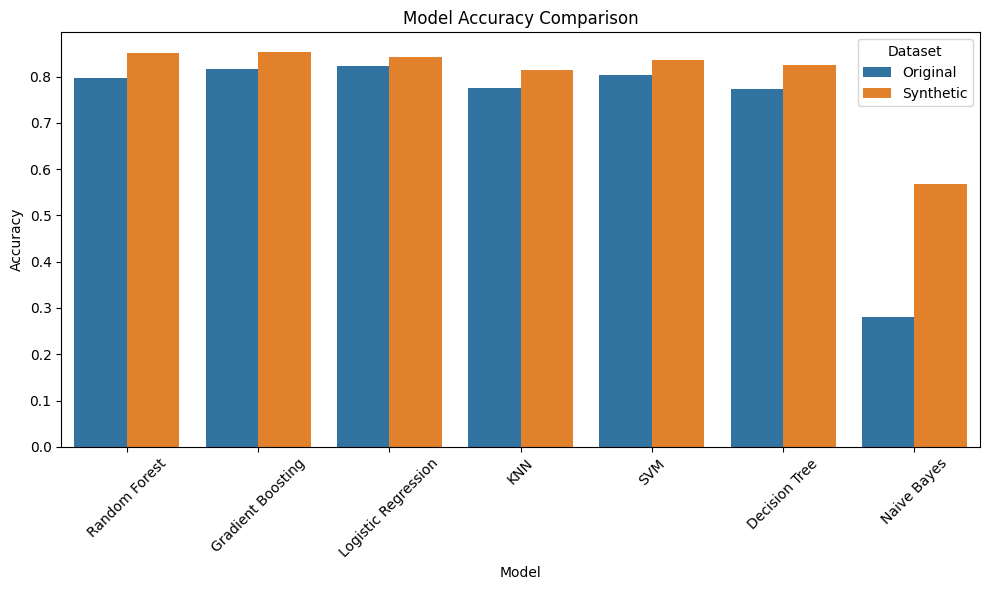

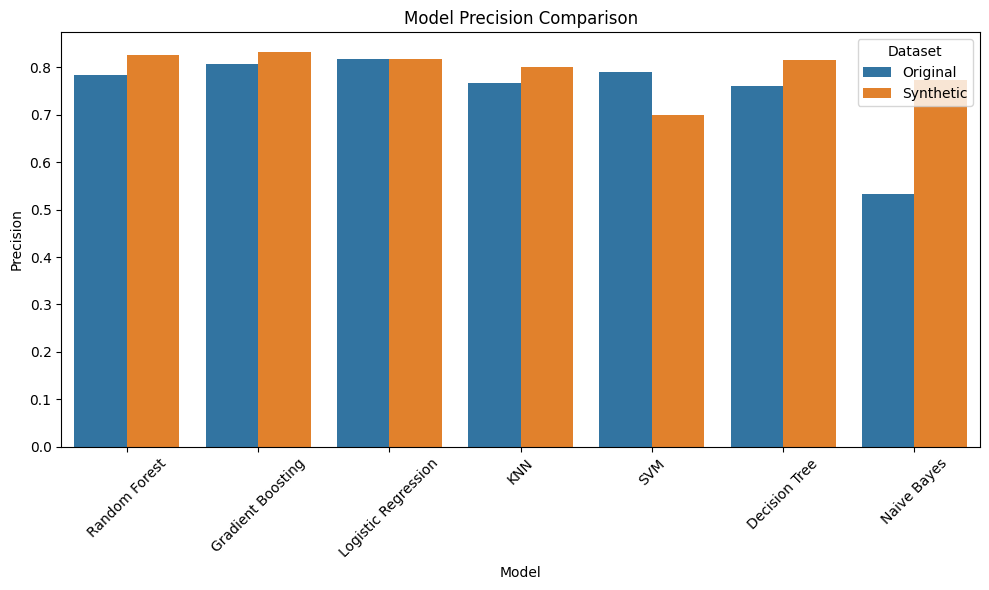

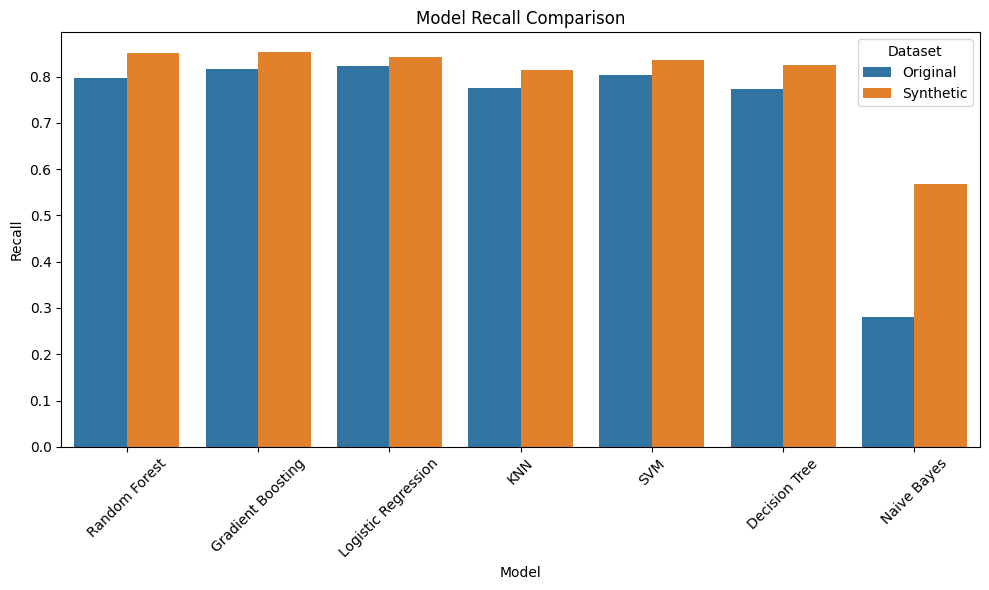

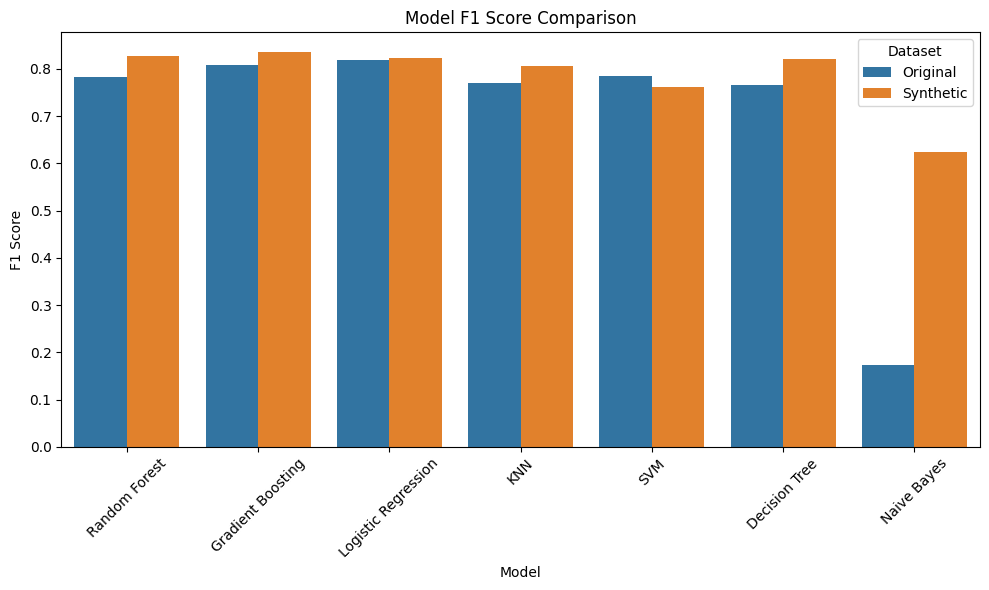

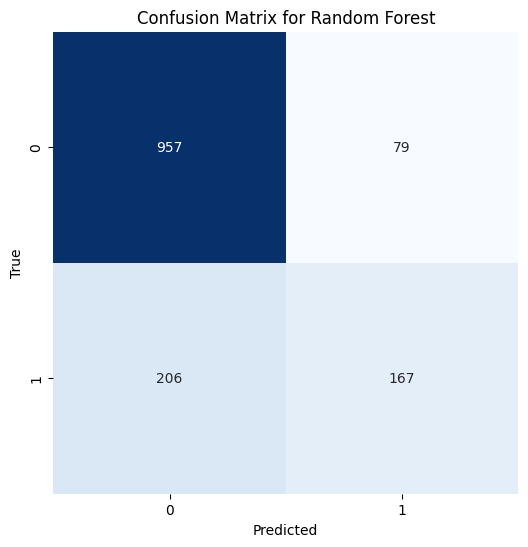


All results saved and visualized!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 12: Plot Results
def plot_results(results):
    """Plot the results of the evaluation metrics."""
    df = pd.DataFrame(results)

    # Reverse the 'Dataset' column for plotting
    df['Dataset'] = df['Dataset'].map({'Original': 'Original', 'Synthetic': 'Synthetic'})

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=df, hue='Dataset')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Precision
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Precision', data=df, hue='Dataset')
    plt.title('Model Precision Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Recall
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Recall', data=df, hue='Dataset')
    plt.title('Model Recall Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot F1 Score
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='F1 Score', data=df, hue='Dataset')
    plt.title('Model F1 Score Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Confusion Matrix for One Model (e.g., Random Forest)
    model_name = 'Random Forest'  # Choose any model you want to plot the confusion matrix for
    conf_matrix = df[df['Model'] == model_name]['Confusion Matrix'].values[0]

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Step 13: Plot the graphs for original and synthetic results
plot_results(original_results + synthetic_results)

print("\nAll results saved and visualized!")


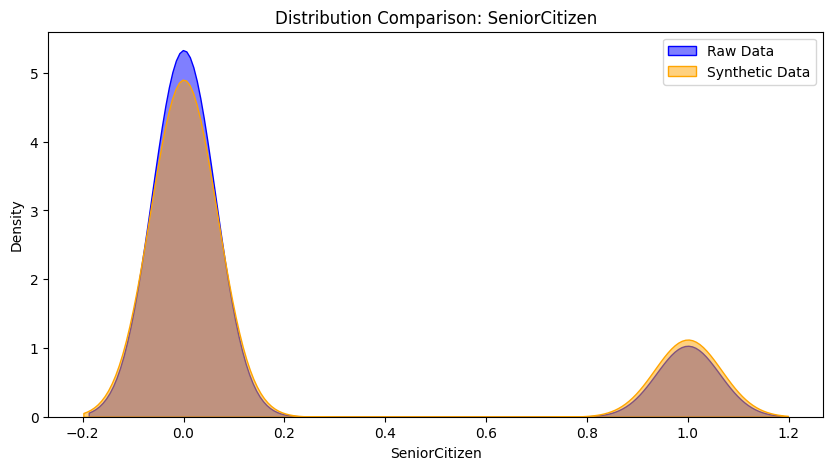

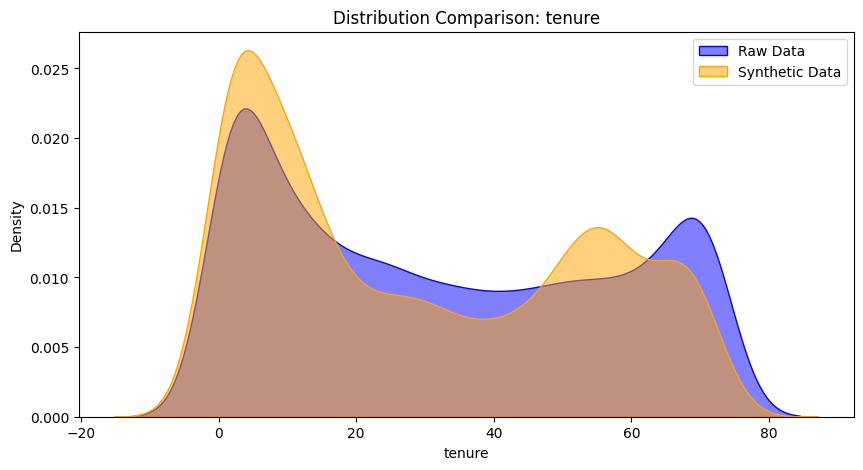

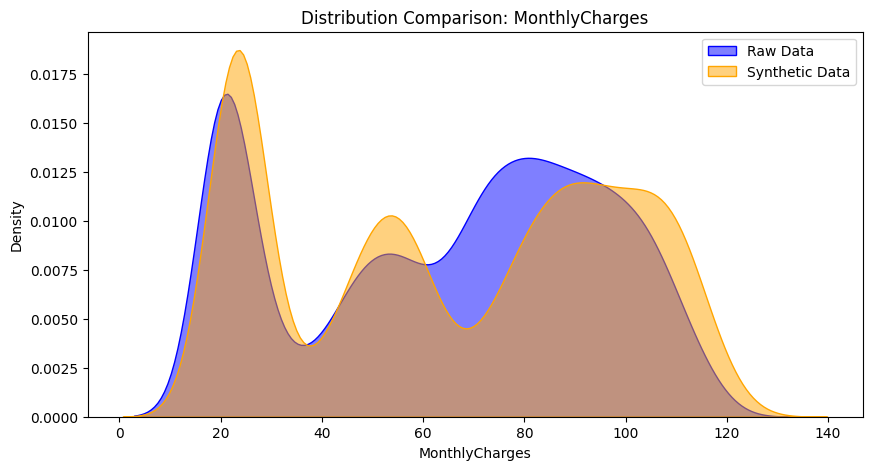

In [ ]:
def plot_numeric_distributions(raw_data, synthetic_data):
    numeric_columns = raw_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    for column in numeric_columns:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(raw_data[column], label='Raw Data', color='blue', fill=True, alpha=0.5)
        sns.kdeplot(synthetic_data[column], label='Synthetic Data', color='orange', fill=True, alpha=0.5)
        plt.title(f'Distribution Comparison: {column}')
        plt.xlabel(column)
        plt.legend()
        plt.show()

plot_numeric_distributions(raw_data, synthetic_data)


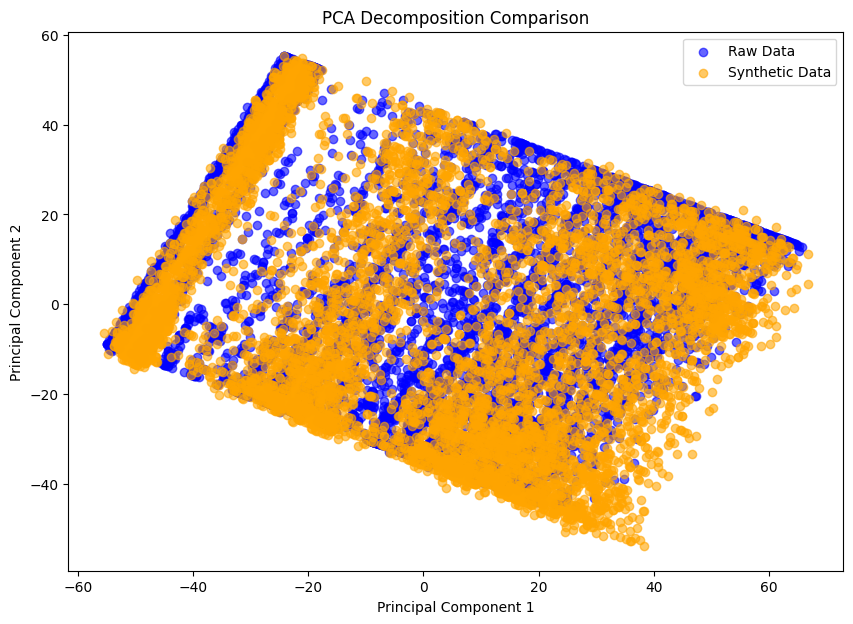

In [ ]:
from sklearn.decomposition import PCA

def plot_pca_comparison(raw_data, synthetic_data):
    numeric_columns = raw_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    pca = PCA(n_components=2)
    raw_pca = pca.fit_transform(raw_data[numeric_columns])
    synthetic_pca = pca.transform(synthetic_data[numeric_columns])

    plt.figure(figsize=(10, 7))
    plt.scatter(raw_pca[:, 0], raw_pca[:, 1], label='Raw Data', color='blue', alpha=0.6)
    plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], label='Synthetic Data', color='orange', alpha=0.6)

    plt.title('PCA Decomposition Comparison')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

plot_pca_comparison(raw_data, synthetic_data)


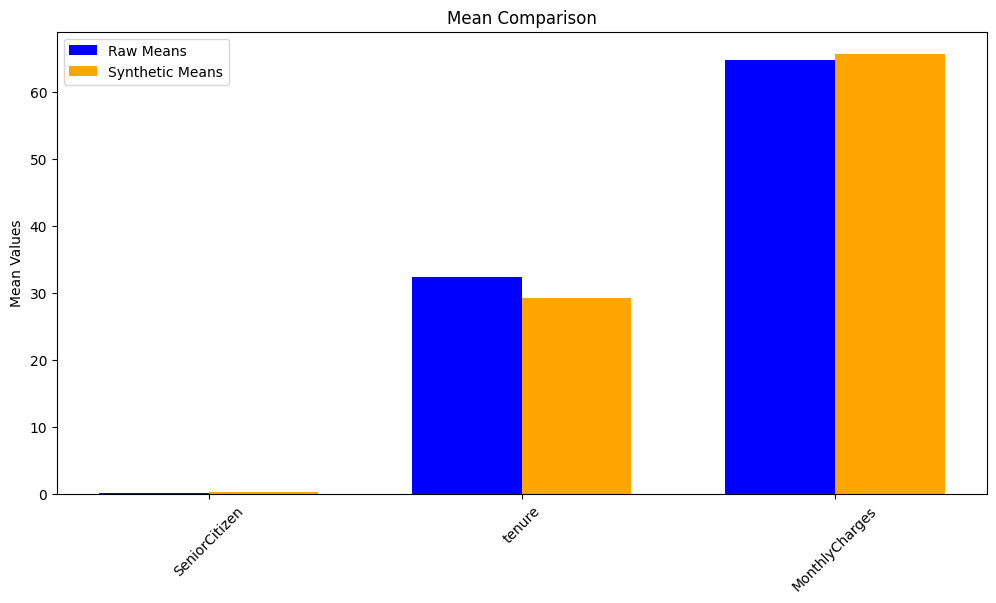

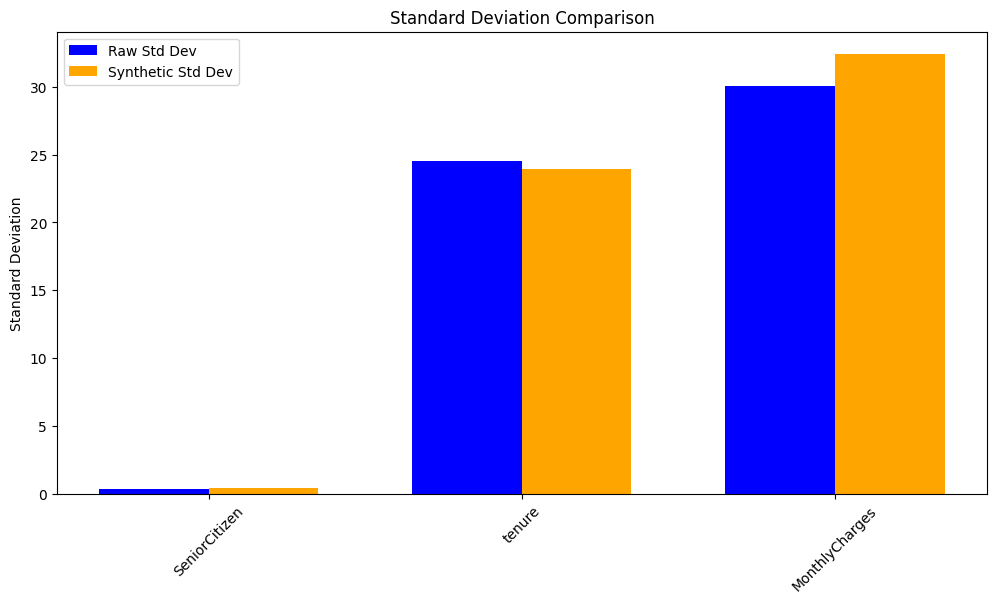

In [ ]:
import numpy as np

def plot_mean_std_comparison(raw_data, synthetic_data):

    numeric_columns = raw_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    raw_means = raw_data[numeric_columns].mean()
    synthetic_means = synthetic_data[numeric_columns].mean()

    raw_stds = raw_data[numeric_columns].std()
    synthetic_stds = synthetic_data[numeric_columns].std()

    x = np.arange(len(numeric_columns))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, raw_means, width, label='Raw Means', color='blue')
    ax.bar(x + width/2, synthetic_means, width, label='Synthetic Means', color='orange')

    ax.set_ylabel('Mean Values')
    ax.set_xticks(x)
    ax.set_xticklabels(numeric_columns, rotation=45)
    ax.legend()
    plt.title('Mean Comparison')
    plt.show()

    # Standard Deviation
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, raw_stds, width, label='Raw Std Dev', color='blue')
    ax.bar(x + width/2, synthetic_stds, width, label='Synthetic Std Dev', color='orange')

    ax.set_ylabel('Standard Deviation')
    ax.set_xticks(x)
    ax.set_xticklabels(numeric_columns, rotation=45)
    ax.legend()
    plt.title('Standard Deviation Comparison')
    plt.show()

plot_mean_std_comparison(raw_data, synthetic_data)
